In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import RMSprop, Adam, SGD
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

**Data preprocessing**

In [38]:
df = pd.read_csv('solarpowergeneration.csv')
df.head(10)

,temperature_2_m_above_gnd,relative_humidity_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,...,wind_direction_10_m_above_gnd,wind_speed_80_m_above_gnd,wind_direction_80_m_above_gnd,wind_speed_900_mb,wind_direction_900_mb,wind_gust_10_m_above_gnd,angle_of_incidence,zenith,azimuth,generated_power_kw
0,2.17,31,1035.0,0.0,0.0,0.0,0,0,0,0.00,...,312.71,9.36,22.62,6.62,337.62,24.48,58.753108,83.237322,128.33543,454.100950
1,2.31,27,1035.1,0.0,0.0,0.0,0,0,0,1.78,...,294.78,5.99,32.74,4.61,321.34,21.96,45.408585,75.143041,139.65530,1411.999400
2,3.65,33,1035.4,0.0,0.0,0.0,0,0,0,108.58,...,270.00,3.89,56.31,3.76,286.70,14.04,32.848282,68.820648,152.53769,2214.849300
3,5.82,30,1035.4,0.0,0.0,0.0,0,0,0,258.10,...,323.13,3.55,23.96,3.08,339.44,19.80,22.699288,64.883536,166.90159,2527.609200
4,7.73,27,1034.4,0.0,0.0,0.0,0,0,0,375.58,...,10.01,6.76,25.20,6.62,22.38,16.56,19.199908,63.795208,182.13526,2640.203400
5,8.69,29,1034.6,0.0,0.0,0.0,0,0,0,449.45,...,23.63,7.10,30.47,6.92,27.90,17.28,25.088167,65.700860,197.22062,2546.081600
6,9.72,27,1034.0,0.0,0.0,0.0,0,0,0,469.92,...,25.02,6.61,29.36,6.44,26.57,12.96,36.197514,70.351498,211.21422,2270.320700
7,10.07,28,1034.1,0.0,0.0,0.0,0,0,0,436.99,...,14.74,7.63,19.29,7.52,16.70,10.80,49.073008,77.228779,223.65641,1063.830200
8,9.38,32,1033.9,0.0,0.0,0.0,0,0,0,353.33,...,6.58,10.50,5.91,10.14,6.12,11.52,62.371140,85.585411,234.50308,86.817611
9,6.54,47,1035.1,0.0,0.0,0.0,0,0,0,228.73,...,360.00,12.25,1.68,11.53,1.79,12.24,105.866560,121.463180,216.06756,9.666667


In [39]:
null_values = df.isnull().sum()
null_values

temperature_2_m_above_gnd            0
relative_humidity_2_m_above_gnd      0
mean_sea_level_pressure_MSL          0
total_precipitation_sfc              0
snowfall_amount_sfc                  0
total_cloud_cover_sfc                0
high_cloud_cover_high_cld_lay        0
medium_cloud_cover_mid_cld_lay       0
low_cloud_cover_low_cld_lay          0
shortwave_radiation_backwards_sfc    0
wind_speed_10_m_above_gnd            0
wind_direction_10_m_above_gnd        0
wind_speed_80_m_above_gnd            0
wind_direction_80_m_above_gnd        0
wind_speed_900_mb                    0
wind_direction_900_mb                0
wind_gust_10_m_above_gnd             0
angle_of_incidence                   0
zenith                               0
azimuth                              0
generated_power_kw                   0
dtype: int64

In [40]:
df = df.interpolate()
duplicates = df.duplicated()
duplicates


0       False
1       False
2       False
3       False
4       False
        ...  
4208    False
4209    False
4210    False
4211    False
4212    False
Length: 4213, dtype: bool

In [41]:
mean = np.mean(df['generated_power_kw'])
std_dev = np.std(df['generated_power_kw'])
outliers = df[(df['generated_power_kw'] > mean + 3*std_dev) | (df['generated_power_kw'] < mean - 3*std_dev)]

# remove outliers
df = df[(df['generated_power_kw'] <= mean + 3*std_dev) & (df['generated_power_kw'] >= mean - 3*std_dev)]
print(mean)
print(std_dev)
print(outliers)

1134.3473126838471
937.8459229238598
Empty DataFrame
Columns: [temperature_2_m_above_gnd, relative_humidity_2_m_above_gnd, mean_sea_level_pressure_MSL, total_precipitation_sfc, snowfall_amount_sfc, total_cloud_cover_sfc, high_cloud_cover_high_cld_lay, medium_cloud_cover_mid_cld_lay, low_cloud_cover_low_cld_lay, shortwave_radiation_backwards_sfc, wind_speed_10_m_above_gnd, wind_direction_10_m_above_gnd, wind_speed_80_m_above_gnd, wind_direction_80_m_above_gnd, wind_speed_900_mb, wind_direction_900_mb, wind_gust_10_m_above_gnd, angle_of_incidence, zenith, azimuth, generated_power_kw]
Index: []

[0 rows x 21 columns]


In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
minmax=df[['wind_speed_10_m_above_gnd', 'generated_power_kw']] = scaler.fit_transform(df[['wind_speed_10_m_above_gnd', 'generated_power_kw']])
print(minmax)


[[0.10411899 0.14855448]
 [0.08417784 0.46192155]
 [0.07649559 0.72456602]
 ...
 [0.14727035 0.05180827]
 [0.11997385 0.04153125]
 [0.18698921 0.00656061]]


**Data Transformation**

In [43]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
best_features = SelectKBest(score_func=f_regression, k=3).fit(X, y)
X_new = best_features.transform(X)

print(X_new)

[[  0.        58.753108  83.237322]
 [  1.78      45.408585  75.143041]
 [108.58      32.848282  68.820648]
 ...
 [113.92      25.249506  65.827032]
 [186.9       36.361161  70.496313]
 [172.66      48.452849  76.919574]]


In [44]:
# feature extraction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
print(X_new)

[[-388.9369362   -23.47003665]
 [-383.09614618  -10.34546897]
 [-274.08892344    2.03846506]
 ...
 [-281.14693998  -58.63264513]
 [-178.90479525  324.06213423]
 [-193.91283575  319.03718823]]


**Data mining**

In [45]:
# clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
clusters = kmeans.predict(X)
print(clusters)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 1 1 1]


In [46]:
# regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
print(y_pred)

[0.39825755 0.47395935 0.56473395 ... 0.19392494 0.16609854 0.02891116]


**Evaluation**

In [47]:
# regression evaluation
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(y, y_pred))
print(r2_score(y, y_pred))

0.027614847712153518
0.7066325899313953


In [48]:
import pickle

In [49]:
pickle.dump(reg, open('reg.pkl','wb'))

**Data reduction**

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

# split the dataset into features and target variable
X = df.drop('wind_speed_80_m_above_gnd', axis=1)
y = df['wind_speed_80_m_above_gnd']

# initialize the PCA object with the desired number of components
pca = PCA(n_components=2)

# fit and transform the dataset using PCA
X_reduced = pca.fit_transform(X)

# create a new dataframe with the reduced features and the target variable
df_reduced = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
df_reduced['wind_speed_80_m_above_gnd'] = y

# save the reduced dataset to a new csv file
df_reduced.to_csv('reduced_dataset.csv', index=False)

**Normalization**

In [ ]:
# import the necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# split the dataset into features and target variable
X = df.drop('wind_speed_80_m_above_gnd', axis=1)
y = df['wind_speed_80_m_above_gnd']

# initialize the MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the dataset using Min-Max scaling
X_normalized = scaler.fit_transform(X)

# create a new dataframe with the normalized features and the target variable
df_normalized = pd.DataFrame(X_normalized, columns=X.columns)
df_normalized['wind_speed_80_m_above_gnd'] = y

# save the normalized dataset to a new csv file
df_normalized.to_csv('normalized_dataset.csv', index=False)


**Binning**

In [ ]:

# split the dataset into features and target variable
X = df.drop('wind_speed_80_m_above_gnd', axis=1)
y = df['wind_speed_80_m_above_gnd']

# define the bin edges and labels
bin_edges = [0, 20, 40, 60, 80, 100]
bin_labels = ['Very low', 'Low', 'Moderate', 'High', 'Very high']

# perform binning using the pandas cut function
X_binned = pd.cut(df['wind_speed_80_m_above_gnd'], bins=bin_edges, labels=bin_labels)


# create a new dataframe with the binned feature and the target variable
df_binned = pd.DataFrame(X_binned, columns=['binned_feature'])
df_binned['wind_speed_80_m_above_gnd'] = y


# save the binned dataset to a new csv file
df_binned.to_csv('binned_dataset.csv', index=False)
X_binned

0       Very low
1       Very low
2       Very low
3       Very low
4       Very low
          ...   
4208         Low
4209    Very low
4210    Very low
4211    Very low
4212    Very low
Name: wind_speed_80_m_above_gnd, Length: 4213, dtype: category
Categories (5, object): ['Very low' < 'Low' < 'Moderate' < 'High' < 'Very high']

**ANN**

In [7]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
print(X.shape, y.shape)
y = np.reshape(y, (-1,1))
y.shape

(4213, 20) (4213,)


(4213, 1)

In [8]:
print(X,y)


[[   2.17       31.       1035.       ...   58.753108   83.237322
   128.33543 ]
 [   2.31       27.       1035.1      ...   45.408585   75.143041
   139.6553  ]
 [   3.65       33.       1035.4      ...   32.848282   68.820648
   152.53769 ]
 ...
 [   7.27       90.       1026.3      ...   25.249506   65.827032
   197.33868 ]
 [   8.25       81.       1025.5      ...   36.361161   70.496313
   211.30027 ]
 [   8.         80.       1025.3      ...   48.452849   76.919574
   223.04931 ]] [[0.14855448]
 [0.46192155]
 [0.72456602]
 ...
 [0.05180827]
 [0.04153125]
 [0.00656061]]


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Shape: {} {} \nTest Shape: {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
     

Train Shape: (3159, 20) (3159, 1) 
Test Shape: (1054, 20) (1054, 1)


In [10]:
from sklearn.preprocessing import StandardScaler
# input scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# outcome scaling:
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)    
y_test = sc_y.transform(y_test)
print("X_train: {}\n X_test:{}\n y_train: {}\n y_test:{}".format(X_train,X_test,y_train,y_test))

X_train: [[-0.15688663 -0.65066193  0.32458773 ... -1.17016507  0.20906612
   0.23973116]
 [-0.96299273  1.26236489 -0.09488224 ...  0.21285162  1.10270022
  -0.59126299]
 [-0.01104135 -0.22554486 -1.44007902 ... -0.78166945 -1.98808451
  -0.32872643]
 ...
 [ 0.08053592 -0.39559169 -0.65899702 ... -1.39867408 -1.07235309
  -0.0910784 ]
 [ 0.34283131 -0.90573217  0.59941288 ... -0.46582577  0.41541699
   0.76311909]
 [-0.6893915   0.62468928  1.45281728 ...  0.28508139  0.20437129
  -0.90996355]]
 X_test:[[ 0.34735364 -1.37336095  0.58494839 ... -0.78124559 -0.35197112
   0.78338018]
 [-1.93190285  1.68748196 -0.84703527 ...  0.34119265  1.11388012
  -0.66875224]
 [-0.95055631  0.28459563  0.97548939 ...  0.32973403 -0.38653881
  -1.09819031]
 ...
 [ 0.69783455 -1.37336095  1.09120525 ... -0.47407508  0.36095606
   0.77638555]
 [-0.00991077 -1.6709429   1.93014517 ... -1.21521633  0.12748879
   0.27526625]
 [-0.58537781  1.00729465 -1.0640025  ...  0.07094803  0.619908
  -0.66549089]]
 

**Defining Accuracy function**

In [19]:

def create_spfnet(n_layers, n_activation, kernels):
  model = tf.keras.models.Sequential()
  for i, nodes in enumerate(n_layers):
    if i==0:
      model.add(Dense(nodes, kernel_initializer=kernels, activation=n_activation, input_dim=X_train.shape[1]))
      #model.add(Dropout(0.3))
    else:
      model.add(Dense(nodes, activation=n_activation, kernel_initializer=kernels))
      #model.add(Dropout(0.3))
  
  model.add(Dense(1),activation='linear')
  model.compile(loss='mse', 
                optimizer='adam',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model


In [20]:
spfnet = create_spfnet([32, 64], 'relu', 'normal')
spfnet.summary()

TypeError: ignored

In [21]:

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam,SGD

In [32]:

hidden_units1 = 10
hidden_units2 = 20
hidden_units3 = 30
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu',input_dim=20),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()
print(model)
     

In [33]:
# loss function
mse = MeanSquaredError()
model.compile(
    loss=mse, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[mse]
)
# train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=150, 
    batch_size=64,
    validation_split=0.2
)
     

Epoch 1/150
40/40 [==============================] - 2s 13ms/step - loss: 0.9931 - mean_squared_error: 0.9943 - val_loss: 1.0285 - val_mean_squared_error: 1.0262
Epoch 2/150
40/40 [==============================] - 0s 5ms/step - loss: 0.5080 - mean_squared_error: 0.5069 - val_loss: 0.3221 - val_mean_squared_error: 0.3217
Epoch 3/150
40/40 [==============================] - 0s 5ms/step - loss: 0.3059 - mean_squared_error: 0.3060 - val_loss: 0.2936 - val_mean_squared_error: 0.2934
Epoch 4/150
40/40 [==============================] - 0s 6ms/step - loss: 0.2767 - mean_squared_error: 0.2767 - val_loss: 0.2748 - val_mean_squared_error: 0.2744
Epoch 5/150
40/40 [==============================] - 0s 5ms/step - loss: 0.2587 - mean_squared_error: 0.2605 - val_loss: 0.2700 - val_mean_squared_error: 0.2697
Epoch 6/150
40/40 [==============================] - 0s 3ms/step - loss: 0.2563 - mean_squared_error: 0.2551 - val_loss: 0.2854 - val_mean_squared_error: 0.2852
Epoch 7/150
40/40 [==============

In [34]:

model.evaluate(X_test,y_test)

33/33 [==============================] - 0s 3ms/step - loss: 0.2404 - mean_squared_error: 0.2405


[0.24039281904697418, 0.24049927294254303]

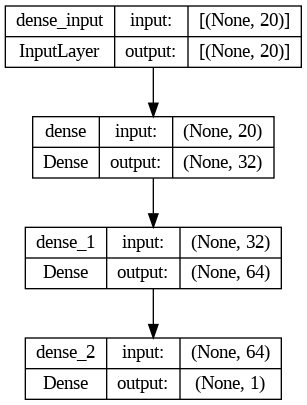

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(spfnet, to_file='spfnet_model.png', show_shapes=True, show_layer_names=True)

In [14]:
hist = spfnet.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test),epochs=150, verbose=2)

Epoch 1/150
99/99 - 2s - loss: 0.5207 - root_mean_squared_error: 0.7216 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5195 - 2s/epoch - 17ms/step
Epoch 2/150
99/99 - 0s - loss: 0.2476 - root_mean_squared_error: 0.4976 - val_loss: 0.2496 - val_root_mean_squared_error: 0.4996 - 238ms/epoch - 2ms/step
Epoch 3/150
99/99 - 0s - loss: 0.2358 - root_mean_squared_error: 0.4856 - val_loss: 0.2395 - val_root_mean_squared_error: 0.4894 - 228ms/epoch - 2ms/step
Epoch 4/150
99/99 - 0s - loss: 0.2298 - root_mean_squared_error: 0.4793 - val_loss: 0.2434 - val_root_mean_squared_error: 0.4933 - 235ms/epoch - 2ms/step
Epoch 5/150
99/99 - 0s - loss: 0.2252 - root_mean_squared_error: 0.4746 - val_loss: 0.2378 - val_root_mean_squared_error: 0.4876 - 210ms/epoch - 2ms/step
Epoch 6/150
99/99 - 0s - loss: 0.2194 - root_mean_squared_error: 0.4684 - val_loss: 0.2412 - val_root_mean_squared_error: 0.4911 - 232ms/epoch - 2ms/step
Epoch 7/150
99/99 - 0s - loss: 0.2156 - root_mean_squared_error: 0.4644 - val_

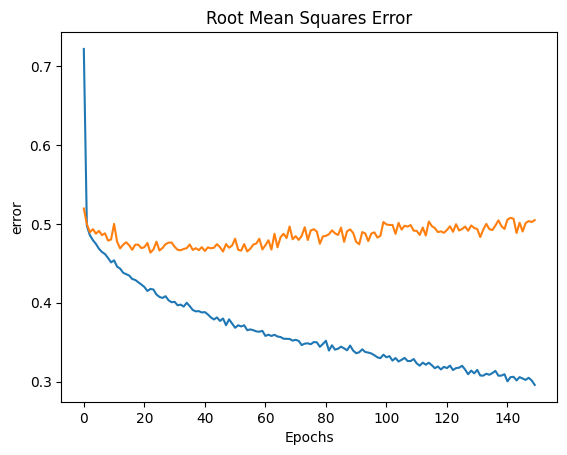

99/99 [==============================] - 0s 2ms/step - loss: 0.0858 - root_mean_squared_error: 0.2930


[0.08583483099937439, 0.2929758131504059]

In [15]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Root Mean Squares Error')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.show()
spfnet.evaluate(X_train, y_train)

In [16]:

import time
import os

def saveModel_path(model_dir="SAVED_MODELS"):
    os.makedirs(model_dir, exist_ok=True)
    fileName = time.strftime("Model_%Y_%m_%d_%H_%M_%S_.h5")    
    model_path = os.path.join(model_dir, fileName)
    print(f"your model will be saved at the following location\n{model_path}")
    return model_path

In [35]:


UNIQUE_PATH = model.save(saveModel_path())

your model will be saved at the following location
SAVED_MODELS/Model_2023_04_19_19_05_55_.h5


In [36]:
model.save_weights("model.h5")

In [ ]:

from sklearn.metrics import mean_squared_error

y_pred = spfnet.predict(X_test) # get model predictions (scaled inputs here)
y_pred_orig = sc_y.inverse_transform(y_pred) # unscale the predictions
y_test_orig = sc_y.inverse_transform(y_test) # unscale the true test outcomes

RMSE_orig = mean_squared_error(y_pred_orig, y_test_orig, squared=False)
RMSE_orig

33/33 [==============================] - 0s 2ms/step


0.14256417660691548

In [ ]:
train_pred = spfnet.predict(X_train) # get model predictions (scaled inputs here)
train_pred_orig = sc_y.inverse_transform(train_pred) # unscale the predictions
y_train_orig = sc_y.inverse_transform(y_train) # unscale the true train outcomes

mean_squared_error(train_pred_orig, y_train_orig, squared=False)

99/99 [==============================] - 0s 1ms/step


0.08693886239365863

In [ ]:

from sklearn.metrics import r2_score
r2_score(y_pred_orig, y_test_orig)
r2_score(train_pred_orig, y_train_orig)
np.concatenate((train_pred_orig, y_train_orig), 1)
np.concatenate((y_pred_orig, y_test_orig), 1)

array([[0.85294026, 0.82152651],
       [0.1488495 , 0.1570942 ],
       [0.5112893 , 0.66002761],
       ...,
       [0.26093888, 0.17125788],
       [0.76034844, 0.81987916],
       [0.2626645 , 0.15864027]])

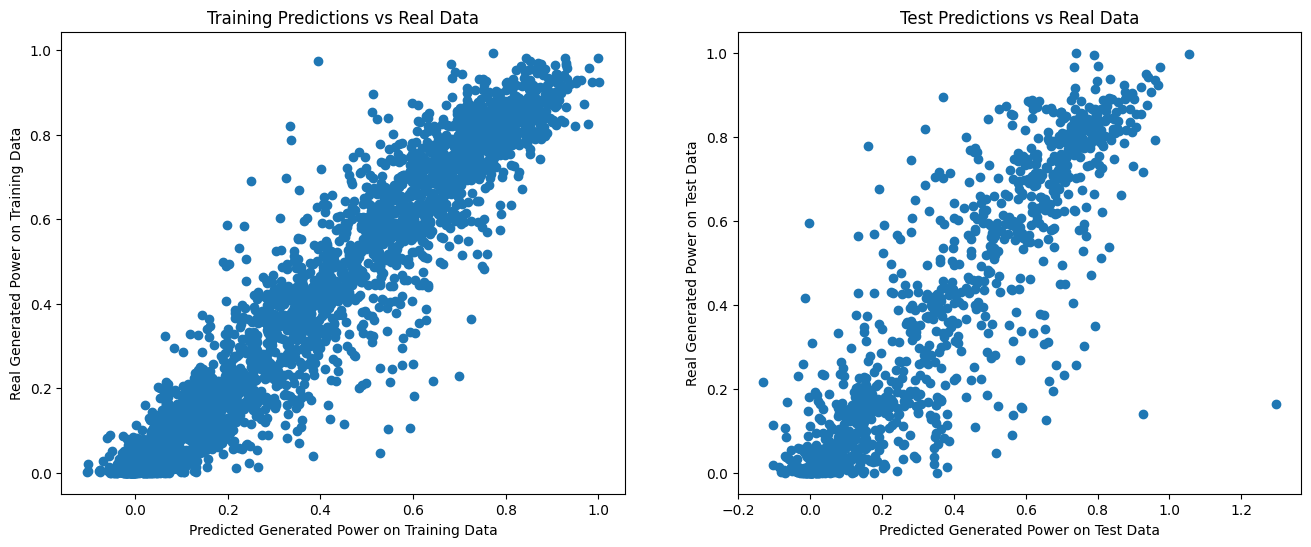

In [ ]:

plt.figure(figsize=(16,6))
plt.subplot(1,2,2)
plt.scatter(y_pred_orig, y_test_orig)
plt.xlabel('Predicted Generated Power on Test Data')
plt.ylabel('Real Generated Power on Test Data')
plt.title('Test Predictions vs Real Data')
#plt.scatter(y_test_orig, sc_X.inverse_transform(X_test)[:,2], color='green')
plt.subplot(1,2,1)
plt.scatter(train_pred_orig, y_train_orig)
plt.xlabel('Predicted Generated Power on Training Data')
plt.ylabel('Real Generated Power on Training Data')
plt.title('Training Predictions vs Real Data')
plt.show()

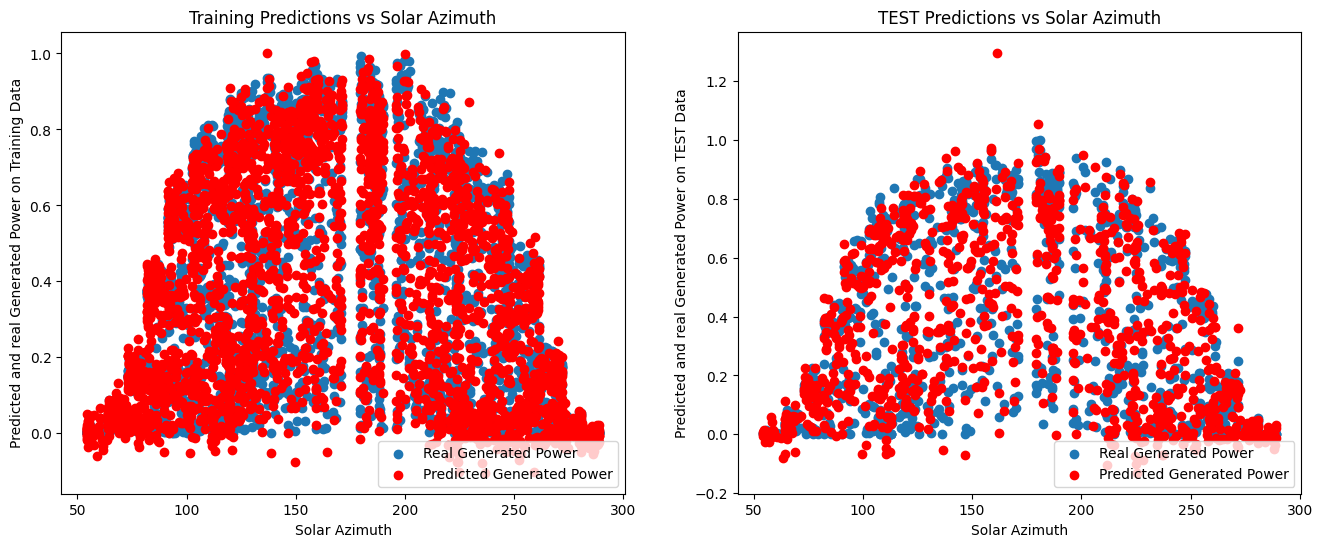

In [ ]:
x_axis = sc_X.inverse_transform(X_train)[:,-1]
x2_axis = sc_X.inverse_transform(X_test)[:,-1]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(x_axis, y_train_orig, label='Real Generated Power')
plt.scatter(x_axis, train_pred_orig, c='red', label='Predicted Generated Power')
plt.ylabel('Predicted and real Generated Power on Training Data')
plt.xlabel('Solar Azimuth')
plt.title('Training Predictions vs Solar Azimuth')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.scatter(x2_axis, y_test_orig, label='Real Generated Power')
plt.scatter(x2_axis, y_pred_orig, c='red', label='Predicted Generated Power')
plt.ylabel('Predicted and real Generated Power on TEST Data')
plt.xlabel('Solar Azimuth')
plt.title('TEST Predictions vs Solar Azimuth')
plt.legend(loc='lower right')
plt.show()

In [ ]:

results = np.concatenate((y_test_orig, y_pred_orig), 1)
results = pd.DataFrame(data=results)
results.columns = ['Real Solar Power Produced', 'Predicted Solar Power']
#results = results.sort_values(by=['Real Solar Power Produced'])
pd.options.display.float_format = "{:,.2f}".format
#results[800:820]
results[7:18]

,Real Solar Power Produced,Predicted Solar Power
7,0.82,0.73
8,0.17,0.19
9,0.30,0.36
10,0.63,0.65
11,0.01,-0.03
12,0.80,0.82
13,0.01,0.38
14,0.27,0.58
15,0.74,0.71
16,0.37,0.33


In [ ]:
sc = StandardScaler()
pred_whole = spfnet.predict(sc.fit_transform(X))
pred_whole_orig = sc_y.inverse_transform(pred_whole)
print(pred_whole_orig,y)

132/132 [==============================] - 0s 1ms/step
[[ 1.5977663e-01]
 [ 5.2530587e-01]
 [ 8.2683879e-01]
 ...
 [-7.9247551e-03]
 [ 2.2247832e-02]
 [-2.4192469e-04]] [[0.14855448]
 [0.46192155]
 [0.72456602]
 ...
 [0.05180827]
 [0.04153125]
 [0.00656061]]


In [ ]:

r2_score(pred_whole_orig, y)

0.8714037732697003

In [ ]:
df_results = pd.DataFrame.from_dict({
    'R2 Score of Whole Data Frame': r2_score(pred_whole_orig, y),
    'R2 Score of Training Set': r2_score(train_pred_orig, y_train_orig),
    'R2 Score of Test Set': r2_score(y_pred_orig, y_test_orig),
    'Mean of Test Set': np.mean(y_pred_orig),
    'Standard Deviation pf Test Set': np.std(y_pred_orig),
    'Relative Standard Deviation': np.std(y_pred_orig) / np.mean(y_pred_orig),
},orient='index', columns=['Value'])
display(df_results.style.background_gradient(cmap='afmhot', axis=0))
     

,Value
R2 Score of Whole Data Frame,0.871404
R2 Score of Training Set,0.908688
R2 Score of Test Set,0.759933
Mean of Test Set,0.362427
Standard Deviation pf Test Set,0.290967
Relative Standard Deviation,0.802831


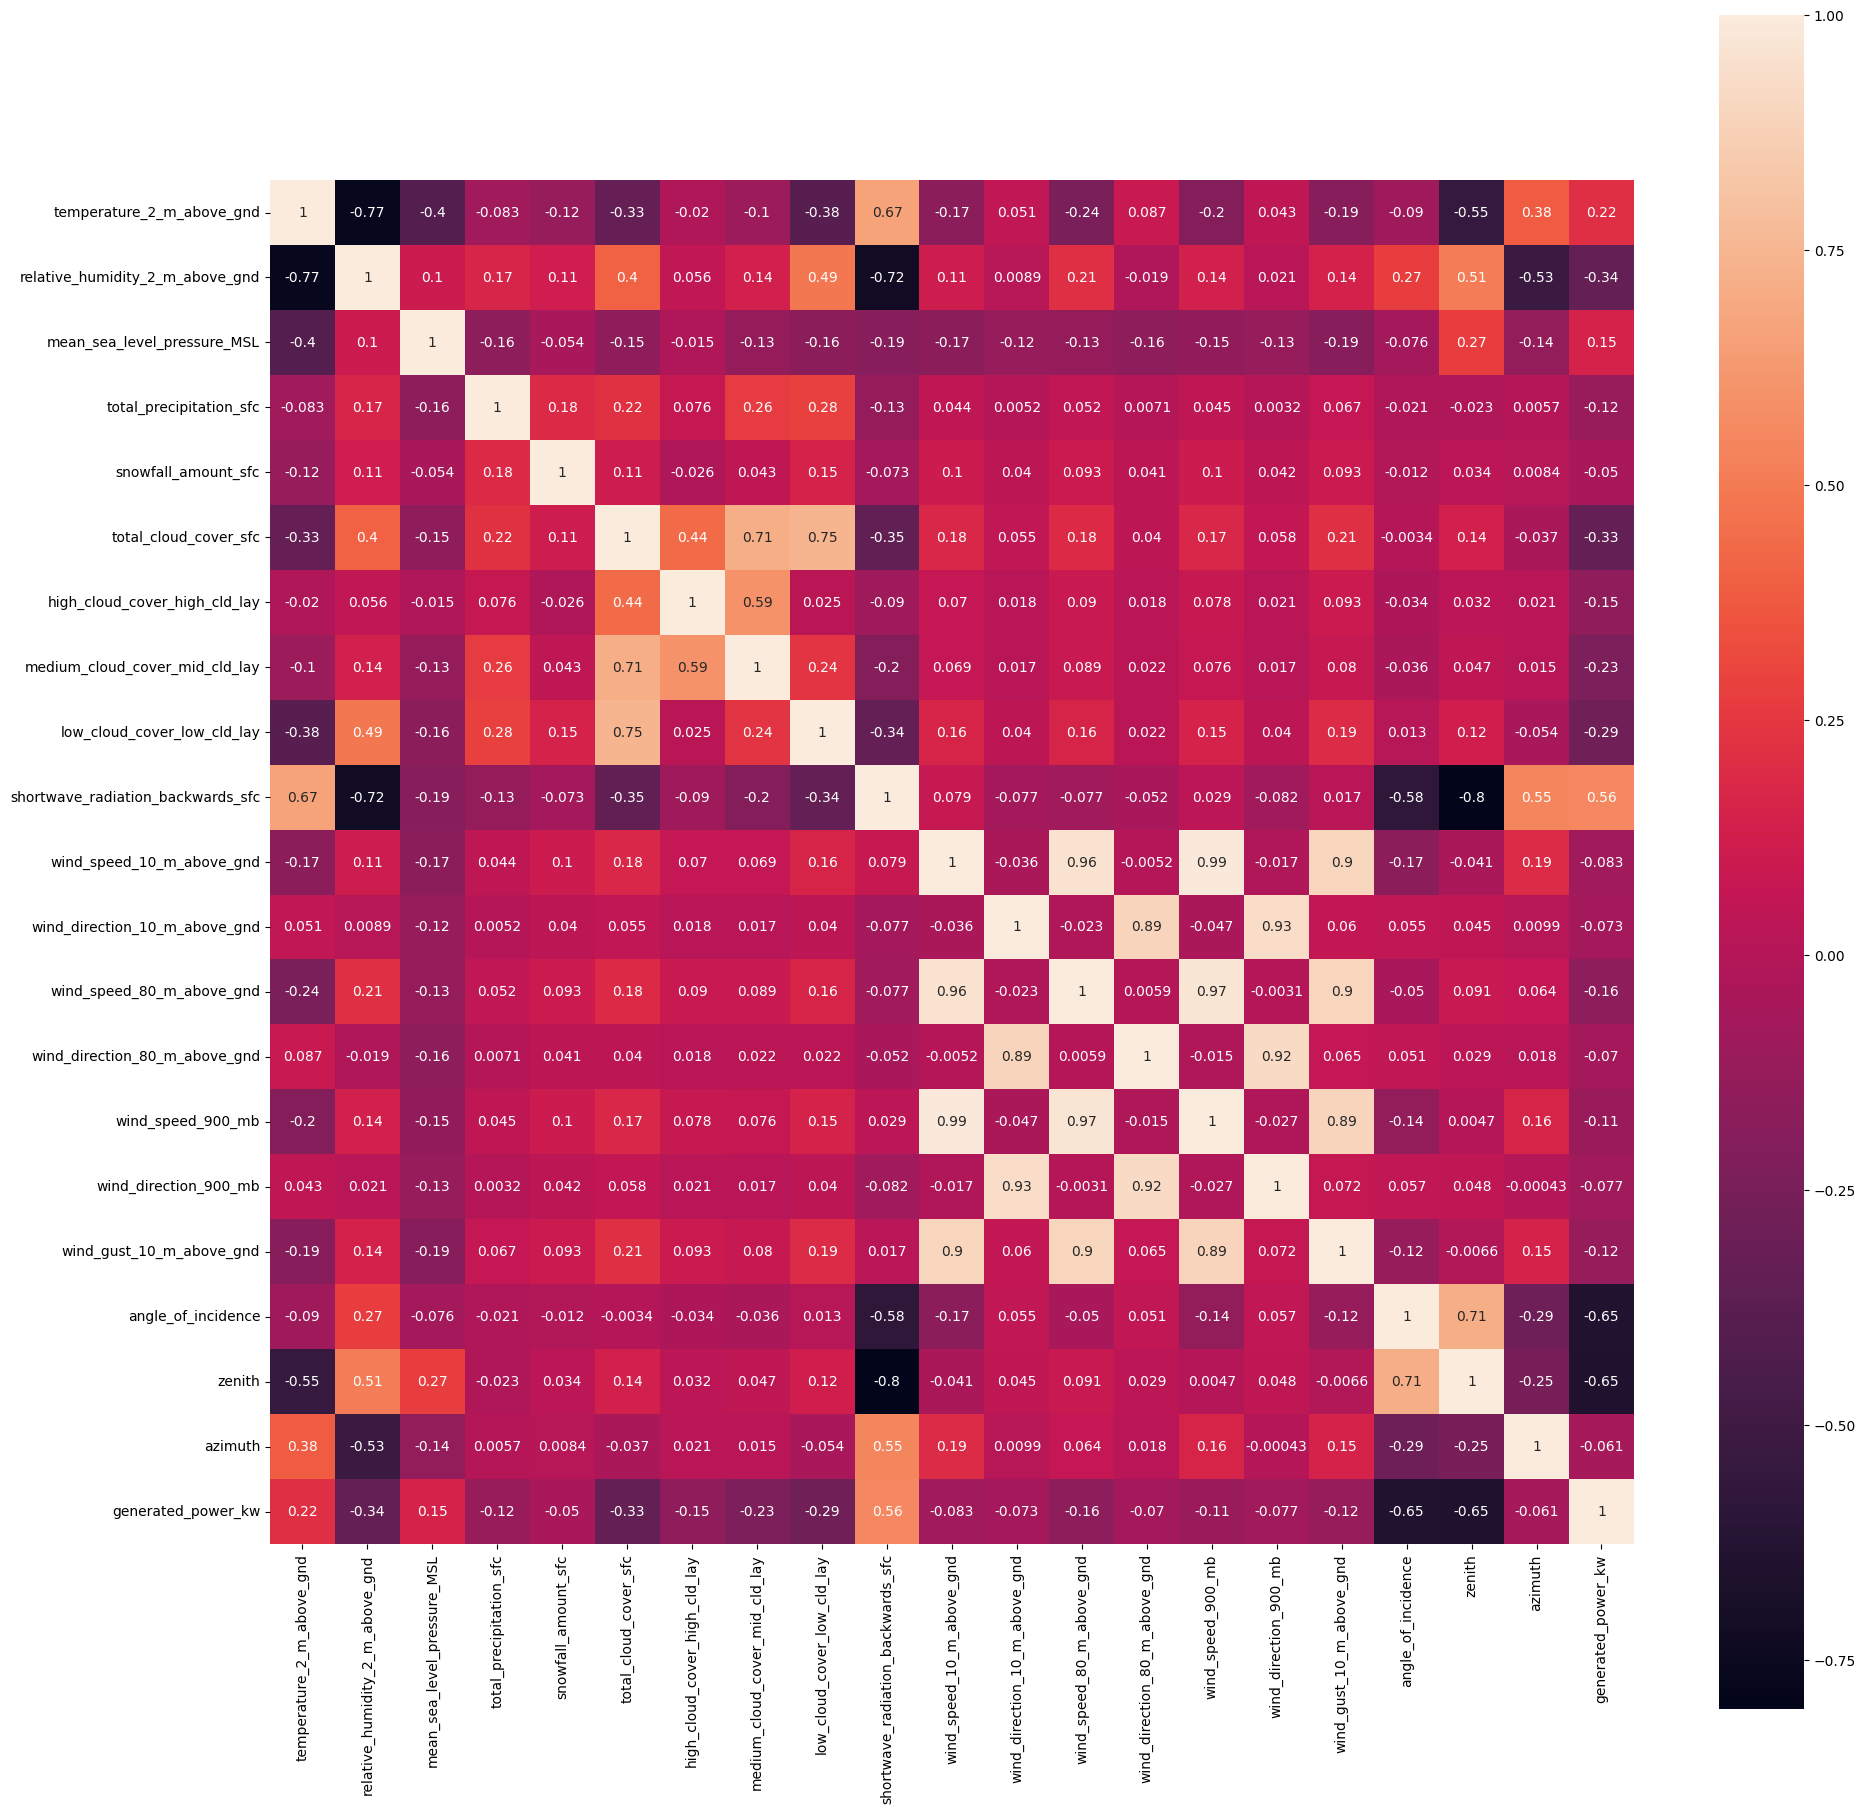

In [ ]:

corr = df.corr()
plt.figure(figsize=(22,22))
sns.heatmap(corr, annot=True, square=True);

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.001)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

lasso_coeff = pd.DataFrame({'Feature Importance':lasso.coef_}, index=df.columns[:-1])
lasso_coeff.sort_values('Feature Importance', ascending=False)

,Feature Importance
shortwave_radiation_backwards_sfc,0.38
mean_sea_level_pressure_MSL,0.12
wind_speed_80_m_above_gnd,0.07
wind_speed_10_m_above_gnd,0.02
snowfall_amount_sfc,0.02
wind_direction_80_m_above_gnd,0.01
wind_direction_10_m_above_gnd,0.01
wind_direction_900_mb,-0.00
total_precipitation_sfc,-0.00
wind_gust_10_m_above_gnd,-0.03


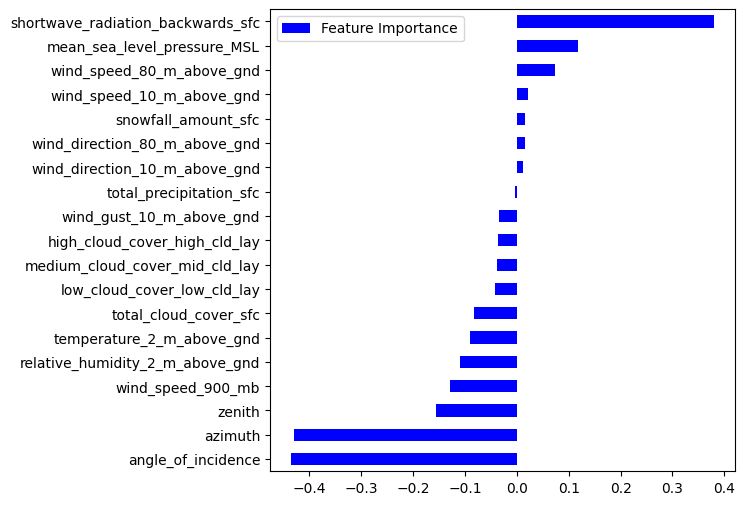

In [ ]:
g = lasso_coeff[lasso_coeff['Feature Importance']!=0].sort_values('Feature Importance').plot(kind='barh',figsize=(6,6), cmap='winter')


In [ ]:
%%shell
jupyter nbconvert --to html ///content/DataminingProject.ipynb

[NbConvertApp] Converting notebook ///content/DataminingProject.ipynb to html
[NbConvertApp] Writing 1876465 bytes to /content/DataminingProject.html


In [ ]:
df.iloc[0]


temperature_2_m_above_gnd               2.17
relative_humidity_2_m_above_gnd        31.00
mean_sea_level_pressure_MSL         1,035.00
total_precipitation_sfc                 0.00
snowfall_amount_sfc                     0.00
total_cloud_cover_sfc                   0.00
high_cloud_cover_high_cld_lay           0.00
medium_cloud_cover_mid_cld_lay          0.00
low_cloud_cover_low_cld_lay             0.00
shortwave_radiation_backwards_sfc       0.00
wind_speed_10_m_above_gnd               0.10
wind_direction_10_m_above_gnd         312.71
wind_speed_80_m_above_gnd               9.36
wind_direction_80_m_above_gnd          22.62
wind_speed_900_mb                       6.62
wind_direction_900_mb                 337.62
wind_gust_10_m_above_gnd               24.48
angle_of_incidence                     58.75
zenith                                 83.24
azimuth                               128.34
generated_power_kw                      0.15
Name: 0, dtype: float64

In [ ]:
new_inputs = np.array([2.17,31.00,1035,0,0,0,0,0,0,0,0.10,312,9,22,6,337,24,58,83,128])
new_inputs.reshape(-1,1)

array([[2.170e+00],
       [3.100e+01],
       [1.035e+03],
       [0.000e+00],
       [0.000e+00],
       [0.000e+00],
       [0.000e+00],
       [0.000e+00],
       [0.000e+00],
       [0.000e+00],
       [1.000e-01],
       [3.120e+02],
       [9.000e+00],
       [2.200e+01],
       [6.000e+00],
       [3.370e+02],
       [2.400e+01],
       [5.800e+01],
       [8.300e+01],
       [1.280e+02]])

In [ ]:
print(spfnet.predict(sc_X.transform(new_inputs)))

ValueError: ignored